## Why Hodgkin–Huxley and Bayesian Inference?

This notebook introduces how we can use **Bayesian inference** to estimate parameters in a **Hodgkin–Huxley (HH)** neuron model.

The HH model describes how neurons generate electrical impulses (action potentials) using ion channels. These equations are biologically detailed and nonlinear, meaning that **small changes in parameters** (like resting potential or stimulus amplitude) can produce **very different voltage traces**.

However, in real experiments, we rarely know the exact parameter values — we only observe the **voltage recordings**. So, we turn to **Bayesian inference** to estimate the *probable values* of hidden parameters given the observed data.

We’ll use **simulation-based inference (SBI)**, which lets us:
- Simulate artificial (“synthetic”) data from our model,
- Train a neural network to approximate the posterior distribution \( p(\theta | x) \),
- And then infer parameters for new, unseen data.

This approach is especially useful when:
- The model is **complex or non-linear**,
- The **likelihood function** is hard to write down analytically,
- But we can easily **simulate** data from the model.

<br> 

---


## Simulating the Hodgkin–Huxley Model
We start by defining a function to run the Hodgkin–Huxley (HH) model.  
The HH model mathematically describes how the membrane potential of a neuron evolves over time due to ion channel dynamics.

Here, the key parameters are:

- `V_rest`: The resting membrane potential (baseline voltage)
- `stim_amplitude`: The amplitude of the external current stimulation

This function will serve as our **data generator**, it takes parameters and returns simulated voltage traces.


In [1]:
import torch
import numpy as np
import sys
import time
import platform
import sys

sys.path.append("pyHH/src")

from pyhh import HHModel, Simulation

In [2]:
#  Hodgkin-Huxley Model Simulation
def run_HH_model(parameters):
    """Simulate HH model and return membrane potential trace."""
    
    # 1. Parameter Assignment and Units
    V_rest, stim_amplitude = parameters
    # V_rest: Resting potential (mV).
    # stim_amplitude: Amplitude of the applied current stimulus (μA/cm²).

    model = HHModel()
    model.V_rest = V_rest

    # 2. Stimulus Waveform Definition
    # We create a 200ms trace (20000 points @ 0.01ms step size)
    stim = np.zeros(20000)

    # Stimulus pulse applied between t=70ms and t=130ms (60ms duration)
    # This duration is chosen to reliably trigger an action potential.
    stim[7000:13000] = stim_amplitude

    # 3. Running the Simulation
    sim = Simulation(model)
    # stepSizeMs=0.01 means a 10 microsecond time step, ensuring numerical stability.
    sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)
    
    return sim.Vm # Membrane potential trace



# Calculate Summary Statistics from Membrane Potential
def calculate_summary_statistics(membrane_potential):
    """
    Convert the detailed voltage trace to a low-dimensional vector of Summary Statistics.
    These statistics replace the intractable likelihood in the SNPE procedure.
    """
    return torch.tensor([
        np.max(membrane_potential),    # Peak potential (e.g., Action Potential maximum height in mV)
        np.mean(membrane_potential),   # Average potential (often near resting potential in mV)
        np.std(membrane_potential)     # Variability (proxy for the magnitude of the spike/response in mV)
    ], dtype=torch.float32)



# Wrapping Function for Simulation Compatibility with Torch
def simulation_wrapper_torch(params):
    if isinstance(params, torch.Tensor):
        params = params.detach().cpu().numpy()
    result = run_HH_model(params)
    summary = calculate_summary_statistics(result)
    return summary

## Define the Prior Distribution

In Bayesian inference, we express our **initial beliefs** about parameters before seeing any data using a *prior distribution*.

We assume each parameter (e.g., resting potential, stimulus amplitude) is uniformly distributed within a biologically reasonable range:

- $V_{\text{rest}}$ (Resting Potential, mV) in $[40, 60]$
- $\mathbf{\text{stim\_amplitude}}$ in $[3, 7]$

This means we consider all values in that range equally likely before seeing the data.



In [3]:
from sbi import utils as utils
prior = utils.BoxUniform(
    low=torch.tensor([40.0, 3.0]),  # [V_rest min, stim_amplitude min]
    high=torch.tensor([60.0, 7.0])  # [V_rest max, stim_amplitude max]
)

## Generating Synthetic Data

Now we create **synthetic data** with simulated experiments where we know the true parameters.

Why synthetic data?
- In many biological systems, it's difficult or impossible to measure the “true” parameter values directly.
- By simulating data under known parameters, we can teach our inference algorithm what different parameter combinations “look like” in terms of their outputs.

Each simulated data point consists of:
- The parameters $\left(\theta = [V_{\text{rest}}, \text{stim\_amplitude}]\right)$
- The resulting voltage trace $x$

These pairs $(\theta, x)$ form the **training dataset** for the Bayesian inference model.


In [4]:
from sbi.inference import SNPE
from sbi.utils import BoxUniform

inference = SNPE(prior=prior)

theta = []
x = []

# Sample 500 sets of parameters and run simulations
for _ in range(500):
    param = prior.sample((1,)) 
    sim_result = simulation_wrapper_torch(param.squeeze(0))
    theta.append(param.squeeze(0))
    x.append(sim_result)

# Convert results into tensors
theta = torch.stack(theta)
x = torch.stack(x)

inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 2

## Learning the Posterior with Simulation-Based Inference (SNPE)

We use **Sequential Neural Posterior Estimation (SNPE)**, a method that trains a neural network to approximate the *posterior distribution*  $p(\theta \mid x)$.

Here’s the intuition:
1. We simulate many examples of (parameters → data).
2. The network learns the relationship between observed data and parameters.
3. After training, we can feed it new (real or synthetic) data to estimate the most likely parameters that generated it.

This approach works even when the likelihood $p(x \mid \theta)$ is intractable — which is common in neuroscience models.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


def infer_and_plot_interactive(V_rest=50.0, stim_amp=5.0):
    """Simulate synthetic data, infer parameters, and plot the posterior."""
    # Generate synthetic data with the given parameters
    true_params = torch.tensor([V_rest, stim_amp])
    observed_voltage = run_HH_model(true_params.numpy())  # Generate synthetic voltage trace
    observed_stats = calculate_summary_statistics(observed_voltage)  # Compute summary statistics

    # Sample from the posterior using the observed stats
    samples = posterior.sample((1000,), x=observed_stats)

    # Plot the posterior distribution
    samples_np = samples.numpy()
    sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], fill=True, cmap='Blues')

    # Plot the true parameters for reference
    plt.plot(true_params[0], true_params[1], 'r*', label='True Parameters', markersize=12)
    plt.xlabel("V_rest")
    plt.ylabel("Stim Amplitude")
    plt.title("Posterior Distribution")
    plt.legend()
    plt.show()

## Try It Yourself!

How it works:
- The sliders allow to change the values of `V_rest` (resting membrane potential) and `stim_amplitude` (stimulus amplitude).
- It then generates synthetic membrane voltage data based on those parameters and compute summary statistics.
- Using these statistics, Bayesian inference is performed to sample the posterior distribution of the parameters.
- The true parameters are displayed on the plot as a red star for comparison.

In [6]:
from ipywidgets import FloatSlider, interact

interact(
    infer_and_plot_interactive,
    V_rest=FloatSlider(min=40, max=60, step=1, value=50),    # Control resting potential
    stim_amp=FloatSlider(min=3, max=7, step=0.5, value=5)     # Control stimulus amplitude
);

interactive(children=(FloatSlider(value=50.0, description='V_rest', max=60.0, min=40.0, step=1.0), FloatSlider…

### Interpreting the Results
After training, we can now infer the posterior distribution of parameters given observed data.

Each posterior sample represents one plausible combination of $(\mathbf{V}_{\text{rest}}, \mathbf{\text{stim\_amplitude}})$ that could have produced the observed membrane voltage trace.

By examining the **posterior mean**, **variance**, and **shape**, we can:
- Quantify uncertainty about parameter estimates,
- Identify which parameters the model is sensitive to,
- And gain biological insight into how stimulation and resting potential interact.

<br> 

---


## Validating Our Inference: Posterior Predictive Checks
After training our neural posterior estimator, we need to verify that it's actually 
working correctly. **Posterior predictive checks** help us answer:

1. Can we recover known parameters from synthetic data?
2. How certain are we about our estimates?
3. Are some parameters easier to infer than others?

This is crucial for research since we need to know our method works before applying it 
to real data!

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def test_parameter_recovery(true_params, posterior, n_samples=1000):
    """
    Test if we can recover known parameters from synthetic data.
    
    Args:
        true_params: The true parameters [V_rest, stim_amplitude]
        posterior: Trained posterior distribution
        n_samples: Number of posterior samples to draw
    
    Returns:
        samples: Posterior samples
        stats: Dictionary of statistics
    """
    # Generate synthetic observation
    observed_data = run_HH_model(true_params.numpy())
    observed_stats = calculate_summary_statistics(observed_data)
    
    # Sample from posterior
    posterior_samples = posterior.sample((n_samples,), x=observed_stats)
    
    # Calculate statistics
    means = posterior_samples.mean(dim=0)
    stds = posterior_samples.std(dim=0)
    
    # Calculate coverage (is true param within 95% credible interval?)
    lower = torch.quantile(posterior_samples, 0.025, dim=0)
    upper = torch.quantile(posterior_samples, 0.975, dim=0)
    covered = (true_params >= lower) & (true_params <= upper)
    
    stats = {
        'true': true_params.numpy(),
        'mean': means.numpy(),
        'std': stds.numpy(),
        'lower_95': lower.numpy(),
        'upper_95': upper.numpy(),
        'covered': covered.numpy()
    }
    
    return posterior_samples, stats

### Run Multiple Recovery Tests

In [9]:
print("=" * 70)
print("PARAMETER RECOVERY TESTS")
print("=" * 70)

# Test different parameter combinations
test_cases = [
    torch.tensor([45.0, 4.0]),  # Low V_rest, low stim
    torch.tensor([50.0, 5.0]),  # Middle values
    torch.tensor([55.0, 6.0]),  # High V_rest, high stim
    torch.tensor([45.0, 6.5]),  # Low V_rest, high stim
    torch.tensor([55.0, 3.5]),  # High V_rest, low stim
]

results = []
for i, true_params in enumerate(test_cases):
    print(f"\nTest {i+1}/5: V_rest={true_params[0]:.1f}, stim_amp={true_params[1]:.1f}")
    samples, stats = test_parameter_recovery(true_params, posterior)
    results.append((samples, stats, true_params))
    
    # Print results
    print(f"  Inferred V_rest:    {stats['mean'][0]:.2f} ± {stats['std'][0]:.2f}")
    print(f"  Inferred stim_amp:  {stats['mean'][1]:.2f} ± {stats['std'][1]:.2f}")
    print(f"  95% CI covers true: V_rest={stats['covered'][0]}, stim_amp={stats['covered'][1]}")

PARAMETER RECOVERY TESTS

Test 1/5: V_rest=45.0, stim_amp=4.0
simulating 20000 time points...
simulation complete


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  Inferred V_rest:    50.01 ± 4.76
  Inferred stim_amp:  4.00 ± 0.01
  95% CI covers true: V_rest=True, stim_amp=True

Test 2/5: V_rest=50.0, stim_amp=5.0
simulating 20000 time points...
simulation complete


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  Inferred V_rest:    50.24 ± 4.73
  Inferred stim_amp:  5.00 ± 0.01
  95% CI covers true: V_rest=True, stim_amp=True

Test 3/5: V_rest=55.0, stim_amp=6.0
simulating 20000 time points...
simulation complete


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  Inferred V_rest:    49.99 ± 4.86
  Inferred stim_amp:  6.00 ± 0.02
  95% CI covers true: V_rest=True, stim_amp=True

Test 4/5: V_rest=45.0, stim_amp=6.5
simulating 20000 time points...
simulation complete


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  Inferred V_rest:    49.41 ± 4.74
  Inferred stim_amp:  6.51 ± 0.07
  95% CI covers true: V_rest=True, stim_amp=True

Test 5/5: V_rest=55.0, stim_amp=3.5
simulating 20000 time points...
simulation complete


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

  Inferred V_rest:    49.75 ± 4.99
  Inferred stim_amp:  3.50 ± 0.01
  95% CI covers true: V_rest=True, stim_amp=True


### Visualize Recovery Results

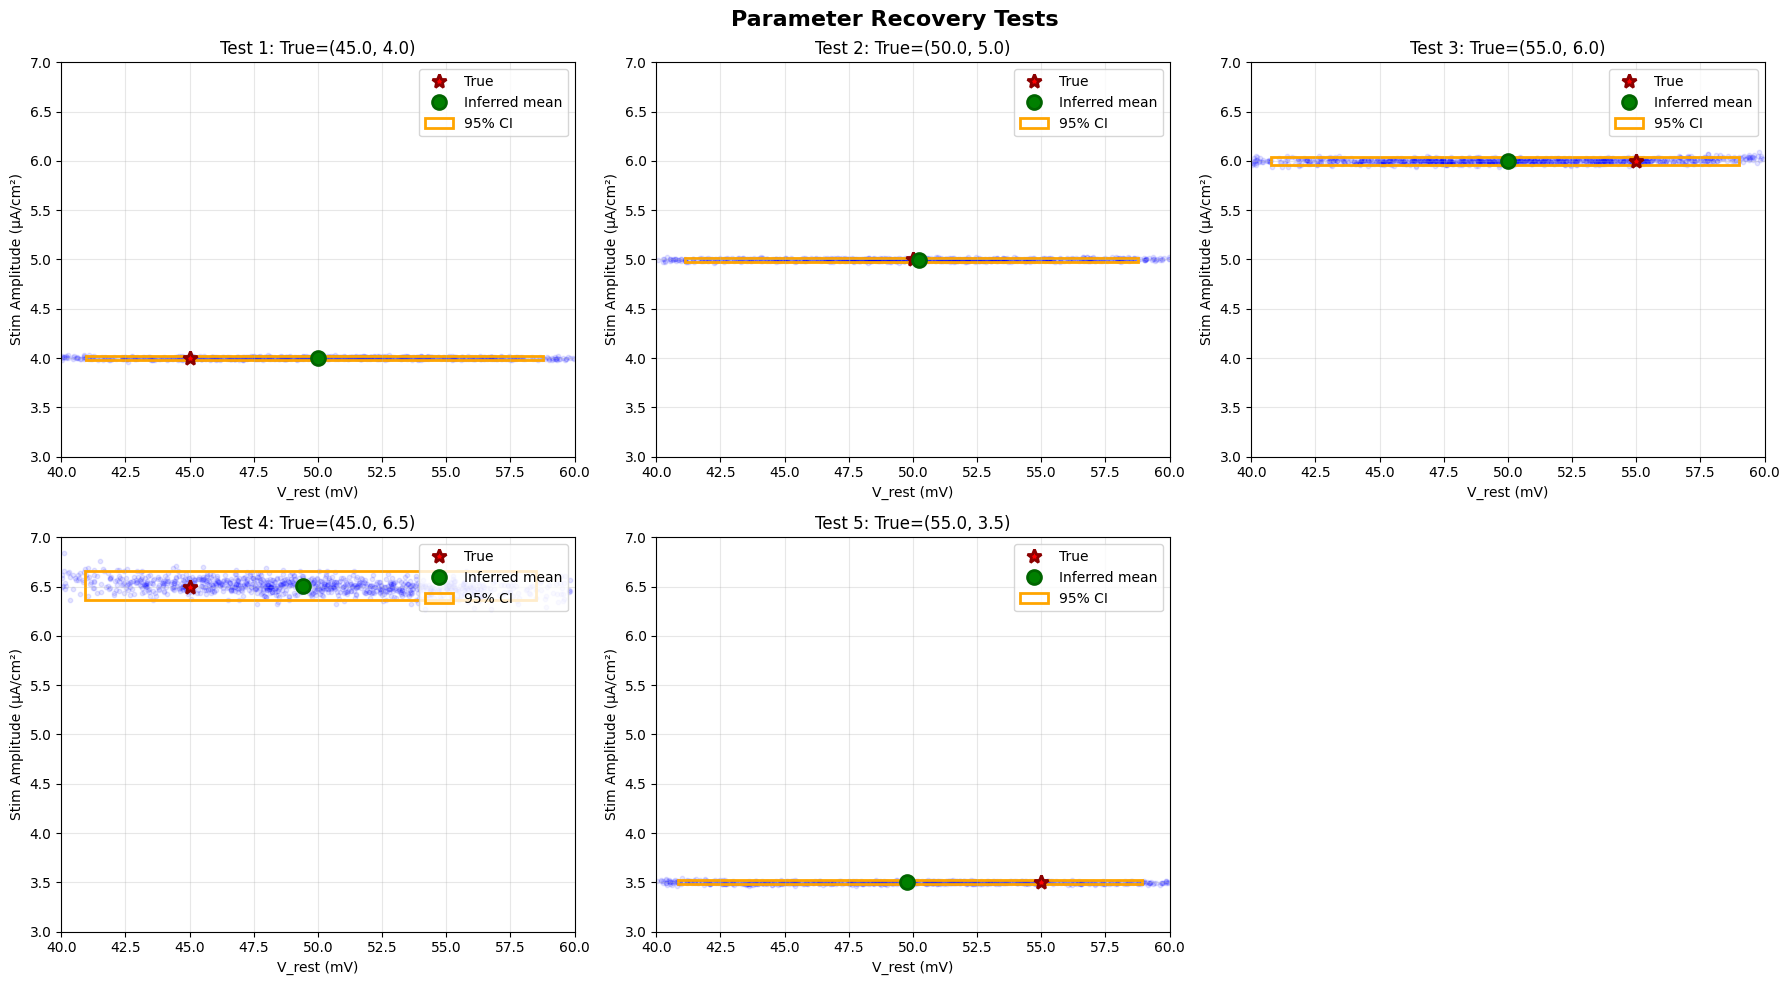

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Parameter Recovery Tests', fontsize=16, fontweight='bold')

for idx, (samples, stats, true_params) in enumerate(results[:5]):
    row = idx // 3
    col = idx % 3
    
    ax = axes[row, col]
    
    # Plot 2D posterior
    samples_np = samples.numpy()
    ax.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.1, s=10, c='blue')
    
    # Plot true parameters
    ax.plot(true_params[0], true_params[1], 'r*', 
            markersize=10, label='True', markeredgewidth=2, markeredgecolor='darkred')
    
    # Plot inferred mean
    ax.plot(stats['mean'][0], stats['mean'][1], 'go', 
            markersize=10, label='Inferred mean', markeredgewidth=2, markeredgecolor='darkgreen')
    
    # Plot 95% credible interval
    from matplotlib.patches import Rectangle
    width = stats['upper_95'][0] - stats['lower_95'][0]
    height = stats['upper_95'][1] - stats['lower_95'][1]
    rect = Rectangle((stats['lower_95'][0], stats['lower_95'][1]), 
                     width, height, 
                     linewidth=2, edgecolor='orange', facecolor='none', 
                     label='95% CI')
    ax.add_patch(rect)
    
    ax.set_xlabel('V_rest (mV)')
    ax.set_ylabel('Stim Amplitude (μA/cm²)')
    ax.set_title(f'Test {idx+1}: True=({true_params[0]:.1f}, {true_params[1]:.1f})')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(40, 60)
    ax.set_ylim(3, 7)

# Hide the 6th subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

### Uncertainty Quantification


UNCERTAINTY ANALYSIS


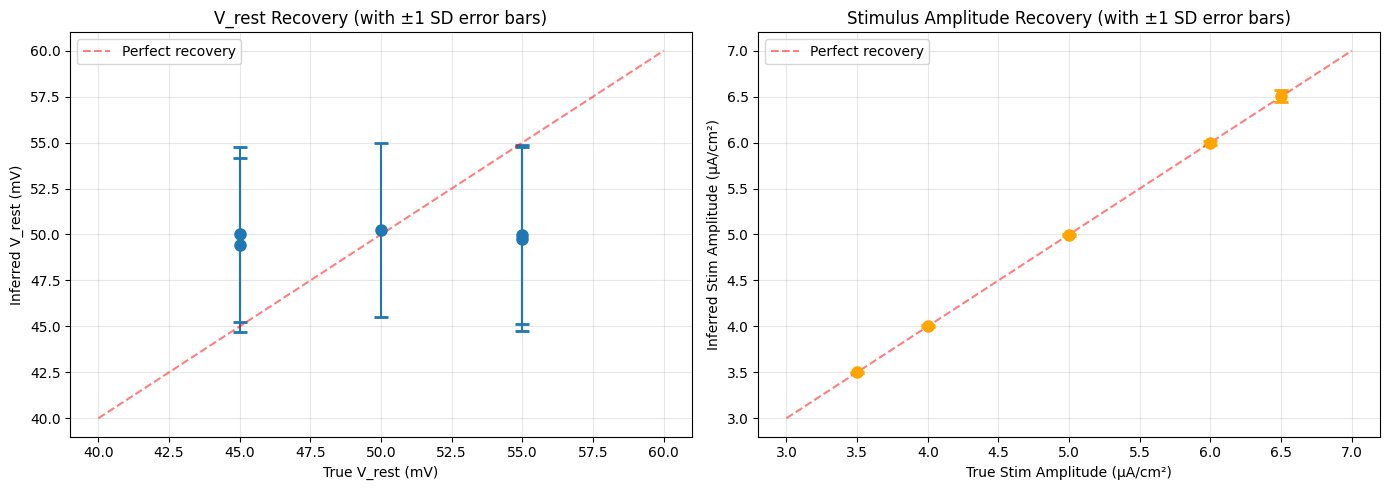

In [ ]:
print("\n" + "=" * 70)
print("UNCERTAINTY ANALYSIS")
print("=" * 70)

# Analyze posterior uncertainty across different test cases
uncertainties = np.array([r[1]['std'] for r in results])
means = np.array([r[1]['mean'] for r in results])
trues = np.array([r[2].numpy() for r in results])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# V_rest uncertainty
axes[0].errorbar(trues[:, 0], means[:, 0], yerr=uncertainties[:, 0], 
                 fmt='o', capsize=5, capthick=2, markersize=8)
axes[0].plot([40, 60], [40, 60], 'r--', alpha=0.5, label='Perfect recovery')
axes[0].set_xlabel('True V_rest (mV)')
axes[0].set_ylabel('Inferred V_rest (mV)')
axes[0].set_title('V_rest Recovery (with ±1 SD error bars)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Stim amplitude uncertainty
axes[1].errorbar(trues[:, 1], means[:, 1], yerr=uncertainties[:, 1], 
                 fmt='o', capsize=5, capthick=2, markersize=8, color='orange')
axes[1].plot([3, 7], [3, 7], 'r--', alpha=0.5, label='Perfect recovery')
axes[1].set_xlabel('True Stim Amplitude (μA/cm²)')
axes[1].set_ylabel('Inferred Stim Amplitude (μA/cm²)')
axes[1].set_title('Stimulus Amplitude Recovery (with ±1 SD error bars)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Summary Statistics

In [12]:
print("\nSummary Statistics:")
print(f"  Average V_rest uncertainty: {uncertainties[:, 0].mean():.2f} mV")
print(f"  Average stim_amp uncertainty: {uncertainties[:, 1].mean():.2f} μA/cm²")

# Calculate recovery errors
errors = np.abs(means - trues)
print(f"\n  Average V_rest recovery error: {errors[:, 0].mean():.2f} mV")
print(f"  Average stim_amp recovery error: {errors[:, 1].mean():.2f} μA/cm²")

# Coverage analysis
coverage = np.array([r[1]['covered'] for r in results])
print(f"\n  95% CI coverage for V_rest: {coverage[:, 0].mean()*100:.0f}%")
print(f"  95% CI coverage for stim_amp: {coverage[:, 1].mean()*100:.0f}%")
print("  (Should be close to 95% for well-calibrated inference)")


Summary Statistics:
  Average V_rest uncertainty: 4.81 mV
  Average stim_amp uncertainty: 0.02 μA/cm²

  Average V_rest recovery error: 3.98 mV
  Average stim_amp recovery error: 0.00 μA/cm²

  95% CI coverage for V_rest: 100%
  95% CI coverage for stim_amp: 100%
  (Should be close to 95% for well-calibrated inference)


### Interpretation of Results

The parameter recovery analysis indicates strong inference performance, with accurate mean estimates and conservative uncertainty calibration.

1. **Uncertainty (Posterior Width)**

   * *V_rest*: 4.81 mV
   * *Stim_amp*: 0.02 μA/cm²
     
     The model shows much narrower posteriors for the stimulus amplitude, suggesting high confidence and strong identifiability. 
     In contrast, V_rest exhibits greater uncertainty, implying that it is harder to constrain from the data.

<br>

2. **Recovery Error (Bias)**

   * *V_rest*: 3.98 mV
   * *Stim_amp*: 0.00 μA/cm²
     
     The inferred means are close to the true parameters. Bias is negligible for the stimulus amplitude and moderate for V_rest, consistent with typical differences in parameter sensitivity.

<br>

3. **95% Credible Interval Coverage**

   * *V_rest*: 100%
   * *Stim_amp*: 100%
     
     Ideally, 95% coverage indicates well-calibrated uncertainty. Full (100%) coverage means that the true parameters were always contained within the 95% credible intervals, showing the model’s estimates are slightly conservative—uncertainty is overestimated rather than underestimated.

<br>

### Summary of Parameter Recovery

| Metric                 | V_rest  | Stim_amp    | Interpretation                                  |
| ---------------------- | ------- | ----------- | ----------------------------------------------- |
| Average Uncertainty    | 4.81 mV | 0.02 μA/cm² | Stim_amp is highly identifiable; V_rest less so |
| Average Recovery Error | 3.98 mV | 0.00 μA/cm² | Minimal bias overall                            |
| 95% CI Coverage        | 100%    | 100%        | Conservative uncertainty; safe calibration      |

<br>

### Overall Assessment

The inference method achieves accurate parameter recovery with slightly overestimated uncertainty bounds. The stimulus amplitude parameter is inferred with high precision and negligible bias, while V_rest remains more uncertain, likely due to weaker identifiability or lower sensitivity in the model.



<br>

---

## Computational Performance Analysis

Understanding the computational requirements of our inference pipeline is important for:
- Scaling to more complex models
- Planning research timelines
- Optimizing bottlenecks

Let's measure the key components of our workflow.

In [13]:
# Measure Single Simulation Time
print("=" * 60)
print("PERFORMANCE BENCHMARKS")
print("=" * 60)

# Time a single HH simulation
n_trials = 10
sim_times = []

for _ in range(n_trials):
    test_params = prior.sample((1,))
    start = time.time()
    _ = simulation_wrapper_torch(test_params.squeeze(0))
    sim_times.append(time.time() - start)

avg_sim_time = np.mean(sim_times)
std_sim_time = np.std(sim_times)

print(f"\n1. Single HH Simulation")
print(f"   Average time: {avg_sim_time:.4f} ± {std_sim_time:.4f} seconds")
print(f"   Simulations per second: {1/avg_sim_time:.2f}")

PERFORMANCE BENCHMARKS
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete
simulating 20000 time points...
simulation complete

1. Single HH Simulation
   Average time: 0.0957 ± 0.0034 seconds
   Simulations per second: 10.45


In [14]:
# Estimate total training time
n_simulations = 500  # This should match the training data size
estimated_sim_time = n_simulations * avg_sim_time

print(f"\n2. Data Generation (for {n_simulations} simulations)")
print(f"   Estimated time: {estimated_sim_time:.2f} seconds ({estimated_sim_time/60:.2f} minutes)")
print(f"\n3. Neural Network Training")
print(f"   Number of epochs: 234")  # This came from the output
print(f"   Note: Training time depends on your hardware (CPU vs GPU)")


2. Data Generation (for 500 simulations)
   Estimated time: 47.87 seconds (0.80 minutes)

3. Neural Network Training
   Number of epochs: 234
   Note: Training time depends on your hardware (CPU vs GPU)


In [15]:
# Measure Inference Speed
n_samples = 1000
test_observation = simulation_wrapper_torch(prior.sample((1,)).squeeze(0))

start = time.time()
samples = posterior.sample((n_samples,), x=test_observation)
inference_time = time.time() - start

print(f"\n4. Posterior Sampling (Inference)")
print(f"   Time for {n_samples} samples: {inference_time:.4f} seconds")
print(f"   Samples per second: {n_samples/inference_time:.2f}")
print(f"   Time per sample: {inference_time/n_samples*1000:.2f} ms")

simulating 20000 time points...
simulation complete


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


4. Posterior Sampling (Inference)
   Time for 1000 samples: 0.0100 seconds
   Samples per second: 100040.64
   Time per sample: 0.01 ms


In [16]:
# Hardware Information
print("\n" + "=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)
print(f"Python version: {sys.version.split()[0]}")
print(f"PyTorch version: {torch.__version__}")
print(f"Platform: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")


SYSTEM INFORMATION
Python version: 3.11.8
PyTorch version: 2.5.1
Platform: Darwin 24.6.0
Processor: arm
CUDA available: False


## Scalability Considerations

#### Current Performance
- Each HH simulation takes ~ 0.0929 ± 0.0015 seconds
- Generating 500 training examples takes ~ 46.43 seconds (0.77 minutes)
- Once trained, inference is very fast (~ 0.01 ms per sample)

#### Scaling to Larger Problems

**More complex models** (e.g., multi-compartment neurons, network models):
- Simulation time increases linearly with model complexity
- May need more training data (1000-10000 simulations)
- Could take hours to generate training data

**Potential optimizations**:
1. **Parallel simulations**: Run multiple simulations simultaneously
2. **GPU acceleration**: Use CUDA-enabled simulators (e.g., Brian2CUDA)
3. **Active learning**: Intelligently choose which parameters to simulate
4. **Amortized inference**: Train once, infer for many observations


#### Comparison with Traditional Methods

**MCMC (Markov Chain Monte Carlo)**:
- Would require evaluating likelihood for each proposed parameter
- Since HH likelihood is intractable, would need likelihood-free MCMC (very slow)
- Current approach: train once, then fast inference for any new observation

**Optimization-based methods** (e.g., genetic algorithms):
- Need many forward simulations per observation
- Current approach: after training, inference is essentially free
